In [212]:
import pandas as pd
import os

In [ ]:
file_df = []
for file in os.listdir("weibo2"):
    if file.endswith(".xlsx"):
        file_df.append(pd.read_excel(f"weibo2/{file}"))

df = pd.concat(file_df)
print(len(df))

df = df.drop_duplicates(subset="博文独立网址")
df['博文'] = df['博文'].str.replace("查看图片", "")
df = df[df["博文"].str.contains("医|药")]
print(len(df))

df[["转发数", "评论数", "点赞数"]] = df[["转发数", "评论数", "点赞数"]].apply(
    lambda col: pd.to_numeric(col, errors="coerce").fillna(0).astype(int)
)

df = df.sort_values("转发数", ascending=False)
df[df["博文"].str.contains("展开")].to_excel("weibo_not_collapsed.xlsx", index=False)
df[~df["博文"].str.contains("展开")].to_excel("weibo_all_collapsed.xlsx", index=False)

df["博文独立网址"] = df["博文独立网址"].str.strip("?refer_flag=1001030103_")

df["发布时间"] = pd.to_datetime(
    "2025年" + df["发布时间"], format="%Y年%m月%d日 %H:%M"  # Add the assumed year
)

/opt/anaconda3/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/opt/anaconda3/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/opt/anaconda3/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/opt/anaconda3/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/opt/anaconda3/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook con

73078
19555


In [ ]:
# Load the fulltext dataset
fulltext = pd.read_excel(
    "weibo_fulltext/temp_微博博文展开全部采集_规则_1_列表_20250301073520921.xlsx"
)
# If fulltext is a DataFrame with potentially multiple rows
for idx, row in fulltext.iterrows():
    if pd.notna(row["博文"]):
        df.loc[df["博文独立网址"] == row["博文独立网址"], "博文"] = row["博文"]

# Load the fulltext dataset
fulltext = pd.read_excel(
    "weibo_fulltext/temp_微博博文展开全部采集_规则_1_列表_20250302043232700.xlsx"
)
# If fulltext is a DataFrame with potentially multiple rows
for idx, row in fulltext.iterrows():
    if pd.notna(row["博文"]):
        df.loc[df["博文独立网址"] == row["博文独立网址"], "博文"] = row["博文"]
        
# 给所有 URL 添加相同的参数
df["博文独立网址"] = df["博文独立网址"] + "?refer_flag=1001030103_"
df = df[df["博文"].str.contains("医|药")]

df[df["博文"].str.contains("展开c")].to_excel("weibo_not_collapsed.xlsx", index=False)
df[~df["博文"].str.contains("展开c")].to_excel("weibo_all_collapsed.xlsx", index=False)

/opt/anaconda3/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/opt/anaconda3/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [ ]:
data = df[~df["博文"].str.contains("展开c")]
data = data[
    [
        "博主id",
        "博主",
        "博主是否认证",
        "博文",
        "博文独立网址",
        "发布时间",
        "发布终端",
        "转发数",
        "评论数",
        "点赞数",
    ]
]
data.columns = [
    "author_id",
    "author",
    "author_type",
    "post",
    "post_url",
    "date",
    "source",
    "repost",
    "comments",
    "likes",
]

In [ ]:
import pandas as pd
import re

def parse_comments(df):
    """
    完整解析包含嵌套评论的数据集，将嵌套评论拆分为独立的评论记录
    同时记录每条评论所回复的前一条评论内容，并保留原始数据集的所有字段
    
    参数:
    df: 包含原始数据的DataFrame，包含'author_id', 'author', 'author_type', 'post', 'post_url', 
        'date', 'source', 'repost', 'comments', 'likes'等列
    
    返回:
    解析后的DataFrame，包含所有独立评论及其回复的评论，保留原始数据的所有字段
    """
    # 创建结果列表
    result_data = []
    
    # 定义正则表达式来匹配转发模式
    repost_pattern = r"//@([^:]+):(.*)"
    
    # 遍历原始数据
    for _, row in df.iterrows():
        # 获取原始数据的所有字段
        author_id = row.get("author_id", "")
        chain_author = row["author"]
        author_type = row.get("author_type", "")
        full_post = row["post"]
        post_url = row.get("post_url", "")
        date = row["date"]
        source = row.get("source", "")
        repost_count = row.get("repost", None)
        comments_count = row.get("comments", None)
        likes_count = row.get("likes", None)
        
        # 用于存储解析出的评论链
        comment_chain = []
        
        # 初始化待处理的评论
        remaining_content = full_post
        current_author = chain_author
        
        while True:
            # 查找下一个转发评论
            match = re.search(repost_pattern, remaining_content)
            
            if match:
                # 提取当前作者的评论(不包括转发部分)
                current_content = remaining_content[:match.start()].strip()
                
                # 记录当前评论
                comment_chain.append({
                    "author": current_author, 
                    "content": current_content
                })
                
                # 更新为下一个作者和剩余内容
                current_author = match.group(1)
                remaining_content = match.group(2).strip()
            else:
                # 没有更多转发，添加最后一条评论
                comment_chain.append({
                    "author": current_author, 
                    "content": remaining_content
                })
                break
        
        # 逆序处理评论链，从最早的评论开始
        comment_chain.reverse()
        
        # 添加额外信息并建立评论之间的关系
        for i, comment in enumerate(comment_chain):
            # 确定是否为原始作者
            is_original_author = (i == len(comment_chain) - 1)
            
            comment_info = {
                # 原始数据字段
                "author_id": author_id if is_original_author else "",  # 仅原始作者保留ID
                "author": comment["author"],
                "author_type": author_type if is_original_author else "",  # 仅原始作者保留类型
                "content": comment["content"],
                "content_url": post_url if is_original_author else "",  # 仅原始作者保留URL
                "date": date,
                "source": source if is_original_author else "",  # 仅原始作者保留来源
                "repost": repost_count if is_original_author else "",  # 仅原始作者保留转发数
                "comments": comments_count if is_original_author else "",  # 仅原始作者保留评论数
                "likes": likes_count if is_original_author else "",  # 仅原始作者保留点赞数
                
                # 额外分析字段
                "chain_author": chain_author,
                "content_len": len([c for c in comment["content"] if '\u4e00' <= c <= '\u9fff']),  # 修正中文字符计数
                "position": (
                    "start" if i == 0 
                    else ("end" if i == len(comment_chain) - 1 else "middle")
                ),
                "index_in_chain": i,
            }
            
            # 添加前一条评论的信息
            if i > 0:
                comment_info["previous_author"] = comment_chain[i - 1]["author"]
                comment_info["previous_content"] = comment_chain[i - 1]["content"]
            else:
                comment_info["previous_author"] = None
                comment_info["previous_content"] = None
                
            result_data.append(comment_info)
    
    # 创建新的DataFrame
    result_df = pd.DataFrame(result_data)
    return result_df

parsed_df = parse_comments(data)
topic_df = parsed_df[parsed_df.content_len > 1]
topic_df.to_xlsx("topic_df.xlsx", index = False)

# Topic modelling

In [222]:
# Import necessary libraries
import pandas as pd
import jieba
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import hanlp  # Use HanLP for tokenization

In [343]:
import hanlp
tok = hanlp.load(hanlp.pretrained.tok.COARSE_ELECTRA_SMALL_ZH)
tok.dict_force = {'原研药', '中成药'}

def preprocess_text(text, stop_words):
    
    if pd.isna(text):
        return None
    
    if len(text) == 0:
        return None
    
    # Use HanLP to segment the text into words
    tokens = tok(text)
    # Remove stop words and tokens with length less than or equal to 1
    tokens = [token for token in tokens if token not in stop_words and len(token) > 1]
    return tokens


In [ ]:
# Define a set of stop words (this list can be extended)
with open('stop_words.txt', 'r', encoding='utf-8') as f:
    stop_words = list(set(line.strip() for line in f if line.strip()))

stop_words.sort()

In [225]:
# Extract the 'content' column from the dataframe and drop any missing values
data = topic_df["content"].dropna().tolist()

# Preprocess each document in the data
tokenized_texts = [preprocess_text(text, stop_words) for text in data]

In [226]:
# Create a dictionary representation of the documents
dictionary = corpora.Dictionary([item for item in tokenized_texts if item is not None])
dictionary.filter_extremes(no_below= 100, no_above=0.3)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

In [227]:
# Function to train LDA models and compute coherence and perplexity scores for different number of topics
def compute_lda_models(dictionary, corpus, tokenized_texts, start, limit, step):
    models = []
    coherence_values = []
    perplexity_values = []
    # Iterate over the specified range of topic numbers
    for num_topics in range(start, limit, step):
        # Train the LDA model with the given number of topics
        lda_model = gensim.models.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=100,
            update_every=1,
            chunksize=100,
            passes=10,
            alpha="auto",
            per_word_topics=True,
        )
        models.append(lda_model)

        # Compute coherence score using the 'c_v' metric
        coherence_model = CoherenceModel(
            model=lda_model,
            texts=tokenized_texts,
            dictionary=dictionary,
            coherence="c_v",
        )
        coherence_score = coherence_model.get_coherence()
        coherence_values.append(coherence_score)

        # Compute log perplexity score (the lower, the better)
        perplexity = lda_model.log_perplexity(corpus)
        perplexity_values.append(perplexity)

        # Print the evaluation metrics for the current model
        print(
            f"Num Topics = {num_topics}, Coherence Score = {coherence_score}, Perplexity = {perplexity}"
        )
    return models, coherence_values, perplexity_values

In [228]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [229]:
# Set the range for number of topics to evaluate
start = 2
limit = 50  
step = 1

# Train LDA models and compute evaluation metrics
models, coherence_values, perplexity_values = compute_lda_models(
    dictionary, corpus, tokenized_texts, start, limit, step
)

Num Topics = 2, Coherence Score = 0.406178491242403, Perplexity = -5.895582056607803
Num Topics = 3, Coherence Score = 0.35787131540926914, Perplexity = -5.755831828855529
Num Topics = 4, Coherence Score = 0.39237603623153994, Perplexity = -5.761005028161568
Num Topics = 5, Coherence Score = 0.45265018508451116, Perplexity = -5.73807266383415
Num Topics = 6, Coherence Score = 0.5135150653818309, Perplexity = -5.709339228777052
Num Topics = 7, Coherence Score = 0.4302473892778357, Perplexity = -5.685214019805467
Num Topics = 8, Coherence Score = 0.41888681591410665, Perplexity = -5.6984783049285
Num Topics = 9, Coherence Score = 0.45912909558156834, Perplexity = -5.649467010590411
Num Topics = 10, Coherence Score = 0.4281394262429548, Perplexity = -5.624067153048379
Num Topics = 11, Coherence Score = 0.45664477034004863, Perplexity = -5.599291683880785
Num Topics = 12, Coherence Score = 0.45996210335173715, Perplexity = -5.578603398730448
Num Topics = 13, Coherence Score = 0.45947458195

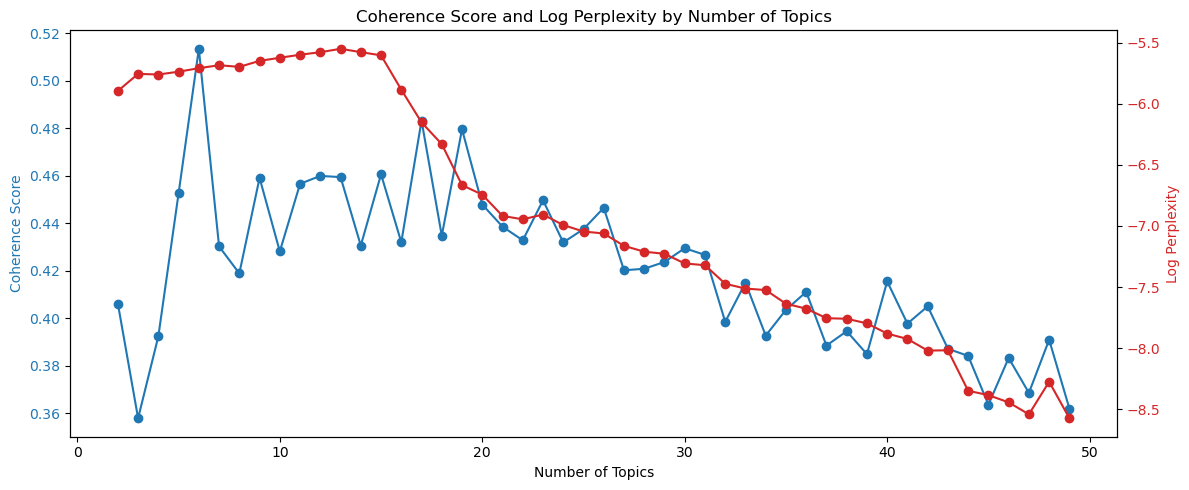

In [230]:
import matplotlib.pyplot as plt

# Create a figure and primary axis
fig, ax1 = plt.subplots(figsize=(12, 5))

# Plot coherence score on the primary y-axis
color1 = 'tab:blue'
ax1.set_xlabel('Number of Topics')
ax1.set_ylabel('Coherence Score', color=color1)
ax1.plot(range(start, limit, step), coherence_values, marker='o', color=color1, label='Coherence Score')
ax1.tick_params(axis='y', labelcolor=color1)

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Log Perplexity', color=color2)
ax2.plot(range(start, limit, step), perplexity_values, marker='o', color=color2, label='Log Perplexity')
ax2.tick_params(axis='y', labelcolor=color2)

# Add a title and ensure layout is neat
plt.title('Coherence Score and Log Perplexity by Number of Topics')
fig.tight_layout()
plt.show()


In [ ]:
num_topics = 19
lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=100,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha="auto",
    per_word_topics=True,
)

In [ ]:
for topic, docs in topic_docs.items():
    print(f"Topic {topic}: {docs}")

In [272]:
documents = data

In [273]:
from collections import defaultdict

# 创建一个字典存储每个主题的代表性文档
topic_docs = defaultdict(list)

# 遍历所有文档
for i, doc in enumerate(corpus):
    topic_dist = lda_model.get_document_topics(doc)  # 获取文档的主题分布
    top_topic = max(topic_dist, key=lambda x: x[1])[0]  # 选择概率最高的主题
    topic_docs[top_topic].append((i, topic_dist))  # 存储文档索引及主题分布

# 选取每个主题中最具代表性的前3个文档
top_n = 3  # 选择代表性文本数量
representative_texts = {}

for topic, docs in topic_docs.items():
    # 确保 `docs` 不是空的
    if not docs:
        continue

    # 重新排序，确保 `x[1]` 是一个字典
    sorted_docs = sorted(docs, key=lambda x: dict(x[1]).get(topic, 0), reverse=True)
    
    rep_texts = [documents[i] for i, _ in sorted_docs[:top_n]]  # 获取对应原始文本
    representative_texts[topic] = rep_texts

# 打印每个主题的代表性文本
for topic, texts in representative_texts.items():
    print(f"\nTopic {topic} Representative Texts:")
    for text in texts:
        print(f"- {text}")



Topic 16 Representative Texts:
- 降价幅度历史最大，多个产品降幅90%以上；药品价格历史最低，阿司匹林肠溶片，中标单价降至三分钱一片。最令人意外的是，原研药在本轮集采中无一中选。民营医院、电商平台、保险公司等相关行业，都在试图抓住原研药带来的新机遇
- #进口药退出公立医院#2024年12月30日，距离开标日18天后，第十批国家药品集中采购结果正式公布。这场集采被业内称为“历史之最”——产品数量历史最多，共493家企业的778个产品参与投标；降价幅度历史最大，多个产品降幅90%以上；药品价格历史最低，阿司匹林肠溶片，中标单价降至三分钱一片。 ​
- 多个产品降幅90%以上；药品价格历史最低，阿司匹林肠溶片，中标单价降至三分钱一片。原研药在本轮集采中无一中选……医药行业真是厉害

Topic 6 Representative Texts:
- 经济观察报：国家高值医用耗材联采办主任高雪被调查经济观察网从多个信源获悉，国家组织高值医用耗材联合采购办公室主任、天津市政协委员、天津市医保局医药采购中心主任高雪被调查。高雪曾任天津市医保局采购中心主任、国家组织高值医用耗材联合采购办公室主任招采组组长、国家组织高值医用耗材联合采购办公室副主任、国家组织高值医用耗材联合采购办公室主任，是高值医用耗材集采重要的操盘手。
- 经济观察报：国家高值医用耗材联采办主任高雪被调查经济观察网从多个信源获悉，国家组织高值医用耗材联合采购办公室主任、天津市政协委员、天津市医保局医药采购中心主任高雪被调查。高雪曾任天津市医保局采购中心主任、国家组织高值医用耗材联合采购办公室主任招采组组长、国家组织高值医用耗材联合采购办公室副主任、国家组织高值医用耗材联合采购办公室主任，是高值医用耗材集采重要的操盘手。
- 经济观察报：国家高值医用耗材联采办主任高雪被调查经济观察网从多个信源获悉，国家组织高值医用耗材联合采购办公室主任、天津市政协委员、天津市医保局医药采购中心主任高雪被调查。高雪曾任天津市医保局采购中心主任、国家组织高值医用耗材联合采购办公室主任招采组组长、国家组织高值医用耗材联合采购办公室副主任、国家组织高值医用耗材联合采购办公室主任，是高值医用耗材集采重要的操盘手。

Topic 1 Representative Texts:
- 复方阿胶浆是进了医保的。两种人

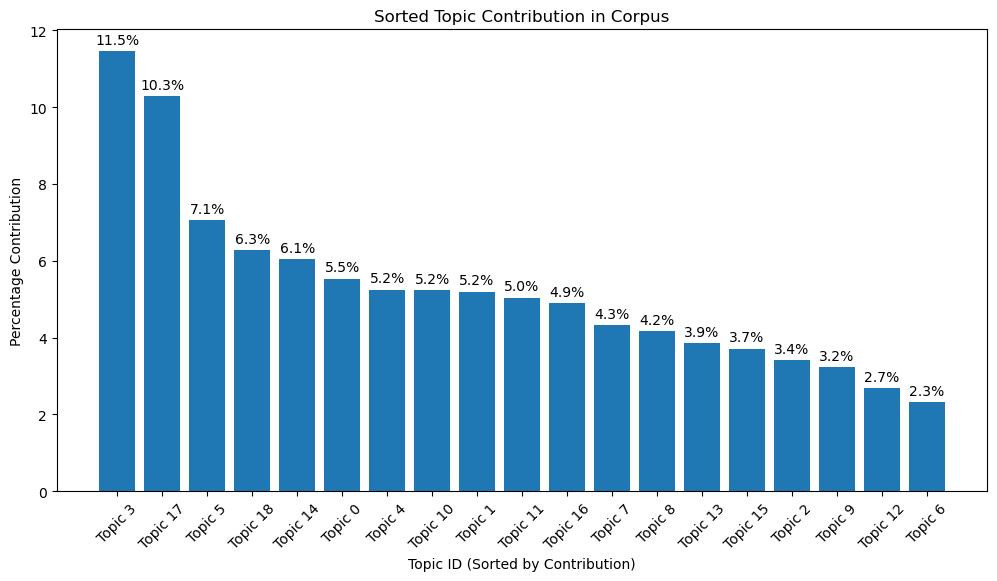

In [281]:
import numpy as np
import matplotlib.pyplot as plt

# 确保 num_topics 变量已定义
num_topics = lda_model.num_topics

# Step 1: 计算主题贡献
topic_contributions = {i: 0 for i in range(num_topics)}

for doc in corpus:
    topic_dist = lda_model.get_document_topics(doc)  # 获取每个文档的主题分布
    for topic_id, prob in topic_dist:
        topic_contributions[topic_id] += prob  # 累加每个主题的概率

# 归一化为百分比
total_contribution = sum(topic_contributions.values())
topic_percentages = {topic: (score / total_contribution) * 100 for topic, score in topic_contributions.items()}

# Step 2: 按贡献排序
sorted_topics = sorted(topic_percentages.items(), key=lambda x: x[1], reverse=True)
topics, percentages = zip(*sorted_topics)  # 解压成两个列表

# Step 3: 绘制排序后的主题贡献
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(range(len(topics)), percentages, tick_label=[f"Topic {t}" for t in topics])

# 在柱子上添加百分比标注
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%', 
                xy=(bar.get_x() + bar.get_width() / 2, height), 
                xytext=(0, 3),  # 3点偏移量
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10, color='black')

ax.set_xlabel("Topic ID (Sorted by Contribution)")
ax.set_ylabel("Percentage Contribution")
ax.set_title("Sorted Topic Contribution in Corpus")
ax.set_xticklabels([f"Topic {t}" for t in topics], rotation=45)

plt.show()


In [283]:
topic_df.to_csv("topic_df.csv", index = False)

In [320]:
original_topic_df = topic_df[topic_df['previous_author'].isna()]

In [359]:
topic_df.to_excel("topic_df.xlsx", index = False)

In [360]:
topic_df

,author_id,author,author_type,content,content_url,date,source,repost,comments,likes,chain_author,content_len,position,index_in_chain,previous_author,previous_content
0,1191965271,三联生活周刊,微博官方认证,【#进口药退出公立医院# 】2024年12月30日，距离开标日18天后，第十批国家药品集中采...,https://weibo.com/1191965271/P9pjHs3Y8?refer_f...,2025-01-13 18:30:00,NaN,21850,4442,9699,三联生活周刊,245,start,0,None,None
1,5766907756,乐子人也,微博个人认证,财新的报道——上海20名政协委员联名提案： 集采之下的国产仿制药现状，麻药不睡，血压不降，泻...,https://weibo.com/5766907756/Pa919drU7?refer_f...,2025-01-18 14:50:00,NaN,13690,795,18992,乐子人也,40,start,0,None,None
2,6827625527,t0mbkeeper,微博个人认证,“血压不降、麻醉不睡、泻药不泻”，瑞金医院副院长郑民华等 20 位委员，共同提交了一份“关于...,https://weibo.com/6827625527/Pa2jWFvCZ?refer_f...,2025-01-17 21:47:00,微博视频号,13281,183,18953,t0mbkeeper,66,start,0,None,None
3,7779120050,雪影甜玉母鸡,NaN,推上看到的: 在日本人写的ABO小说里，大体上，抑制剂费用总是由医保承担，政府不仅会负担民众...,https://weibo.com/7779120050/Pa98kmUIo?refer_f...,2025-01-18 15:08:00,iPhone 16 Pro,7854,410,38973,雪影甜玉母鸡,160,start,0,None,None
4,1231148270,Summer最聪明,微博个人认证,这两天，北京和上海政协委员纷纷提案，希望国家关注集采药效果不佳、副反应大的问题，在微博上引起...,https://weibo.com/1231148270/ParA86Jn6?refer_f...,2025-01-20 14:06:00,微博网页版,5284,994,16389,Summer最聪明,2587,start,0,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60221,,小草根读者雷有国,,医药由于集采，还在下行通道，要极致耐心，等到极为便宜，才是买入机会。,,2025-01-02 08:29:00,,,,,志坚意定,29,start,0,None,None
60223,6270728135,卷无邪,NaN,医院集采了中药注射液，中成药先说中药注射液，本质不是中药，是用西药的研究方法，把中药制成注射...,https://weibo.com/6270728135/P7FBObui4?refer_f...,2025-01-02 08:18:00,Xiaomi 15,0,0,1,卷无邪,109,start,0,None,None
60224,5681923486,连板大本贏家林晓英,微博个人认证,行业财经要闻1. 我国首部能源法正式施行 2025年将新增风电光伏装机约2亿千瓦2. 新华社...,https://weibo.com/5681923486/P7FqQAIjG?refer_f...,2025-01-02 07:51:00,热门财经Android,0,2,166,连板大本贏家林晓英,284,start,0,None,None
60225,,真诚的知识分享,,转：医药集采之后，商业保险公司的“百万医疗”就基本上失去存在的意义了！“百万医疗”推出的初衷...,,2025-01-02 07:45:00,,,,,yr902018,103,start,0,None,None
